In [1]:
import os, csv
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.utils import np_utils
from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

In [2]:
type_mapping = {} # pokemon type (string) => pokemon type (integer)
type_mapping_reversed = {} # pokemon type (integer) => pokemon type (string)
pokemon_type_mapping = {} # pokemon name => pokemon type1 (integer)

types = ['Fire', 'Water', 'Normal','Grass']
#'Grass', 'Poison', 'Fire', 'Flying', 'Water', 'Bug', 'Normal', 'Electric', 'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Steel', 'Ice', 'Ghost', 'Dragon', 'Dark'

i = 0
with open('pokemon.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # skip header
    for row in reader:
        if row[1] in types or (len(row) > 2 and row[2] in types):
            if row[1] in types:
                if row[1] not in type_mapping:
                    type_mapping[row[1]] = i
                    type_mapping_reversed[i] = row[1]
                    i += 1
                pokemon_type_mapping[row[0]] = type_mapping[row[1]]
            if len(row) > 2 and row[2] in types:
                if row[2] not in type_mapping:
                    type_mapping[row[2]] = i
                    type_mapping_reversed[i] = row[2]
                    i += 1
                pokemon_type_mapping[row[0]] = type_mapping[row[2]]


In [3]:

# original jpgs are (120 x 120 x 3) while original pngs are (120 x 120 x 4)
# change all pngs so that they are (120 x 120 x 3) and convert to jpg
# probably better to convert png -> jpg rather than jpg -> png
# because removing the alpha channel doesn't remove info (png -> jpg)
# but adding the alpha channel adds unnecessary info (jpg -> png)

# i = 0
# for filename in os.listdir('images'):
#     if filename.endswith(".png"):
#         im = Image.open(f'images/{filename}').convert('RGBA')
#         pokemon_name = filename[:-4]
#         background = Image.new("RGB", im.size, (255, 255, 255))
#         background.paste(im, mask=im.split()[-1])
#         name=f'images/{pokemon_name}.jpg'
#         background.save(name, 'JPEG')
# #         os.remove(f'images/{filename}') # delete original png image
#         i += 1

# print(f'{i} images converted')


In [4]:
# feature matrix will have 43200 columns

X = []
y = []
z = []

for pokemon_name in pokemon_type_mapping.keys():
    i = mpimg.imread(f'images/{pokemon_name}.jpg')
    X.append(i)
    y.append(pokemon_type_mapping[pokemon_name])
    z.append(pokemon_name)

In [5]:
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.25, random_state=5)

y_train = np_utils.to_categorical(y_train, len(types))
y_test = np_utils.to_categorical(y_test, len(types))

# convert to numpy arrays so keras won't complain
X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
y_train = np.array(y_train)
y_test = np.array(y_test)

In [6]:
model = Sequential()

imported_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(120,120,3),
                   pooling='avg',classes=len(types),
                   weights='imagenet')
# for layer in imported_model.layers:
#         layer.trainable=False

model.add(imported_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [7]:
fitted_model = model.fit(X_train, y_train, validation_split=0.33, epochs=20, verbose=1)

Epoch 1/20
7/7 [==============================] - 10s 732ms/step - loss: 1.4734 - accuracy: 0.3929 - val_loss: 4.0383 - val_accuracy: 0.3093
Epoch 2/20
7/7 [==============================] - 4s 617ms/step - loss: 0.8192 - accuracy: 0.7296 - val_loss: 7.5707 - val_accuracy: 0.2784
Epoch 3/20
7/7 [==============================] - 4s 571ms/step - loss: 0.4631 - accuracy: 0.8418 - val_loss: 15.2030 - val_accuracy: 0.2680
Epoch 4/20
7/7 [==============================] - 4s 545ms/step - loss: 0.3048 - accuracy: 0.9235 - val_loss: 13.9204 - val_accuracy: 0.2887
Epoch 5/20
7/7 [==============================] - 4s 539ms/step - loss: 0.2997 - accuracy: 0.8980 - val_loss: 12.8740 - val_accuracy: 0.3299
Epoch 6/20
7/7 [==============================] - 4s 567ms/step - loss: 0.2816 - accuracy: 0.9235 - val_loss: 22.8532 - val_accuracy: 0.2887
Epoch 7/20
7/7 [==============================] - 4s 535ms/step - loss: 0.3296 - accuracy: 0.9286 - val_loss: 21.8631 - val_accuracy: 0.2990
Epoch 8/20
7/7

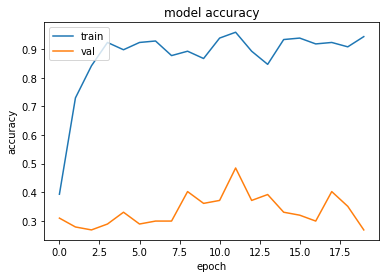

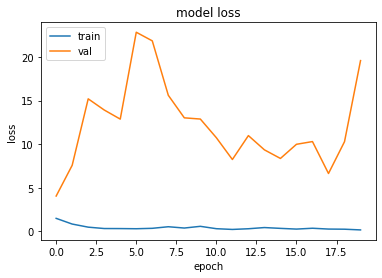

In [8]:
# summarize history for accuracy
plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
# Evaluation:
score = model.evaluate(X_test, y_test, verbose=1)
print('The accuracy is: ', score[1])

4/4 [==============================] - 0s 82ms/step - loss: 21.5344 - accuracy: 0.2041
The accuracy is:  0.20408163964748383


In [10]:
y_predict = model.predict(X_test)

4/4 [==============================] - 1s 81ms/step


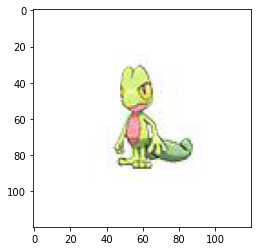

treecko is Grass. model predicted Fire


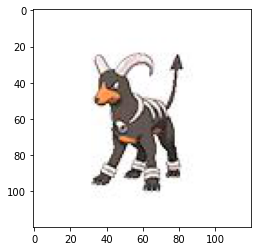

houndoom is Fire. model predicted Fire


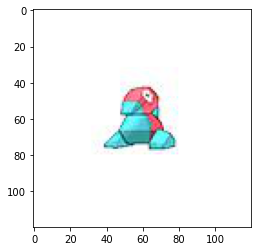

porygon is Normal. model predicted Fire


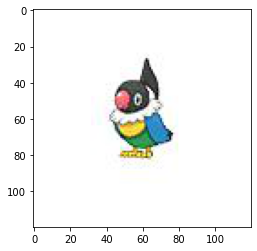

chatot is Normal. model predicted Fire


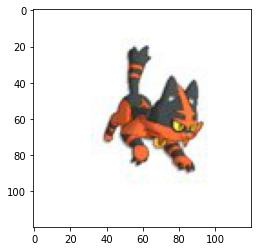

torracat is Fire. model predicted Fire


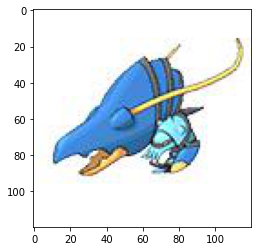

clawitzer is Water. model predicted Fire


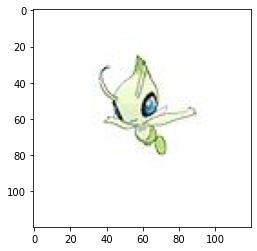

celebi is Grass. model predicted Fire


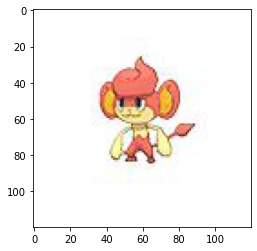

pansear is Fire. model predicted Fire


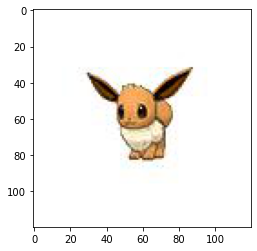

eevee is Normal. model predicted Fire


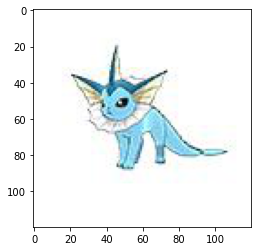

vaporeon is Water. model predicted Fire


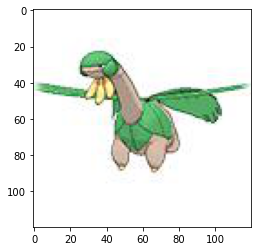

tropius is Grass. model predicted Fire


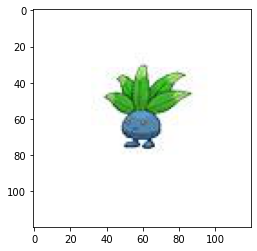

oddish is Grass. model predicted Fire


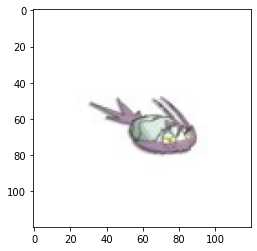

wimpod is Water. model predicted Fire


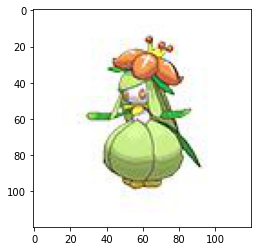

lilligant is Grass. model predicted Fire


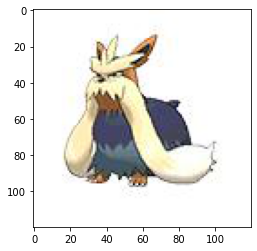

stoutland is Normal. model predicted Fire


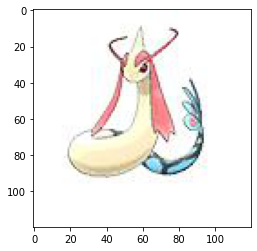

milotic is Water. model predicted Fire


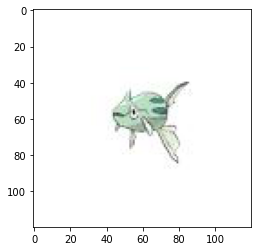

remoraid is Water. model predicted Fire


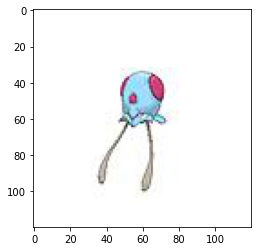

tentacool is Water. model predicted Fire


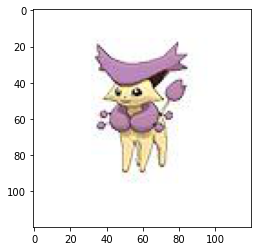

delcatty is Normal. model predicted Fire


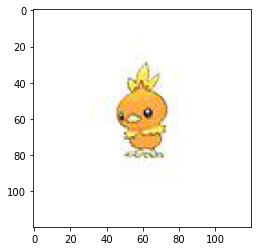

torchic is Fire. model predicted Fire


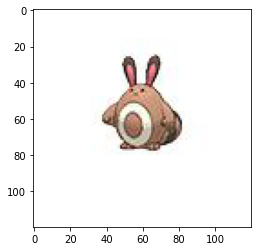

sentret is Normal. model predicted Fire


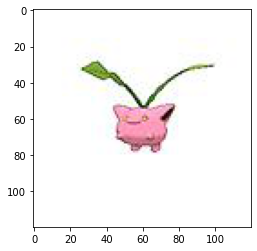

hoppip is Grass. model predicted Fire


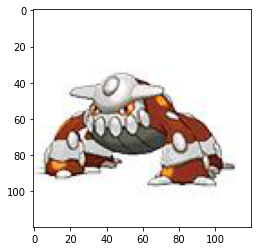

heatran is Fire. model predicted Fire


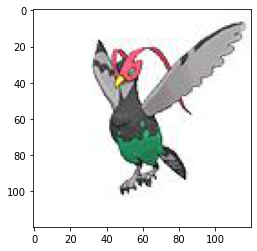

unfezant is Normal. model predicted Fire


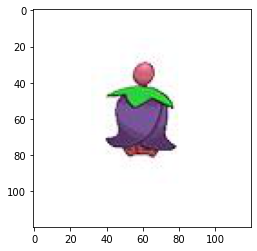

cherrim is Grass. model predicted Fire


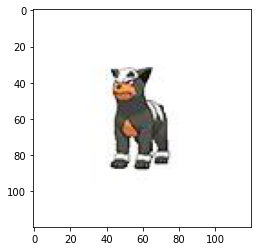

houndour is Fire. model predicted Fire


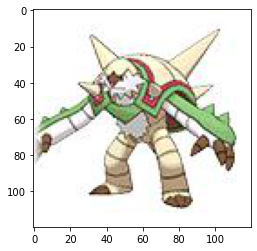

chesnaught is Grass. model predicted Fire


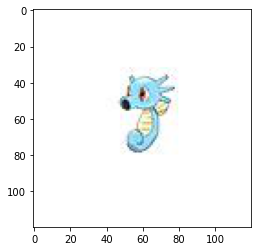

horsea is Water. model predicted Fire


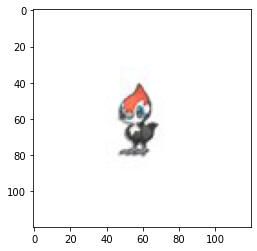

pikipek is Normal. model predicted Fire


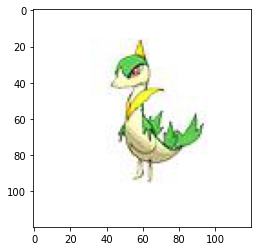

servine is Grass. model predicted Fire


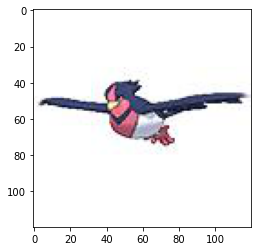

swellow is Normal. model predicted Fire


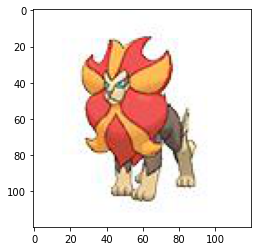

pyroar is Normal. model predicted Fire


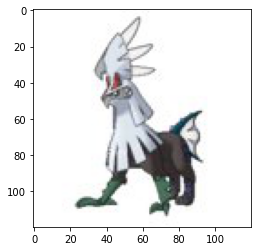

silvally is Normal. model predicted Fire


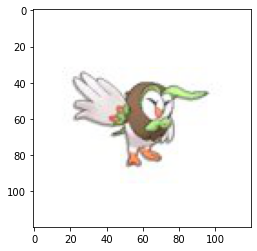

dartrix is Grass. model predicted Fire


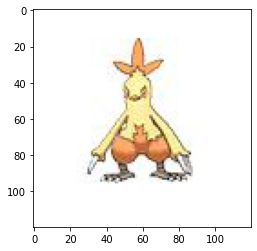

combusken is Fire. model predicted Fire


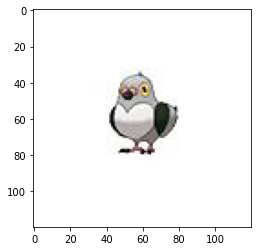

pidove is Normal. model predicted Fire


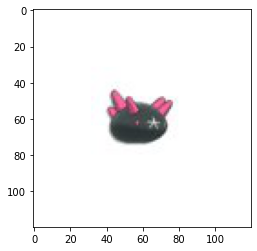

pyukumuku is Water. model predicted Fire


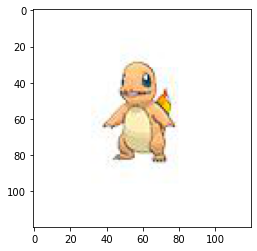

charmander is Fire. model predicted Fire


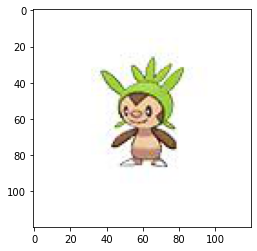

chespin is Grass. model predicted Fire


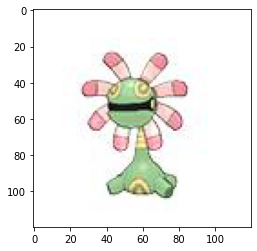

cradily is Grass. model predicted Fire


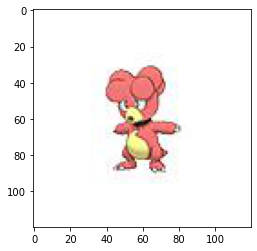

magby is Fire. model predicted Fire


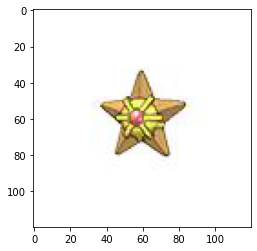

staryu is Water. model predicted Fire


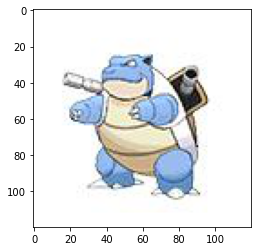

blastoise is Water. model predicted Water


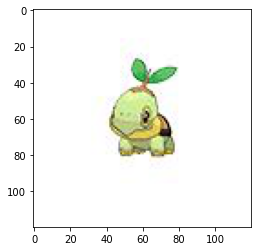

turtwig is Grass. model predicted Fire


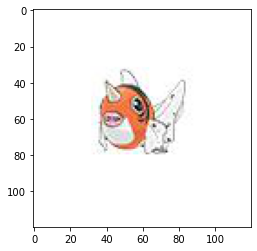

seaking is Water. model predicted Fire


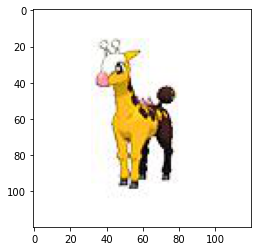

girafarig is Normal. model predicted Fire


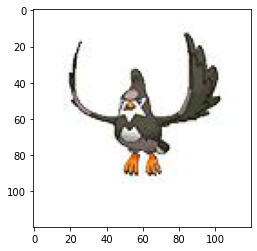

staravia is Normal. model predicted Fire


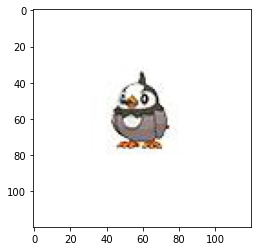

starly is Normal. model predicted Fire


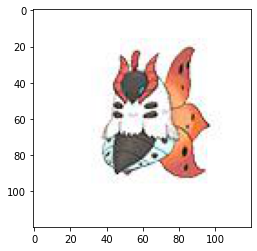

volcarona is Fire. model predicted Fire


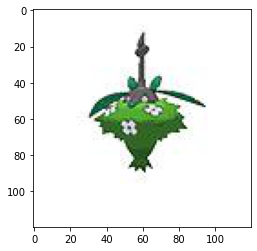

wormadam-plant is Grass. model predicted Fire


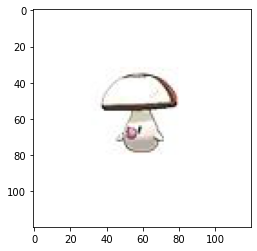

foongus is Grass. model predicted Fire


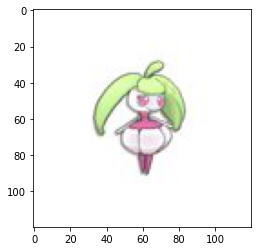

steenee is Grass. model predicted Fire


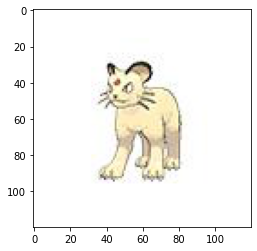

persian is Normal. model predicted Fire


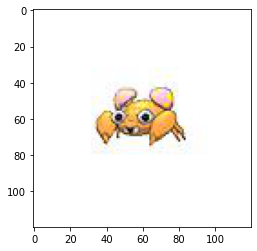

paras is Grass. model predicted Fire


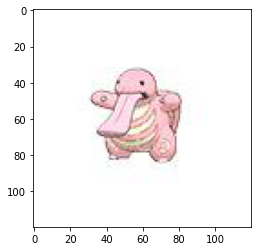

lickitung is Normal. model predicted Fire


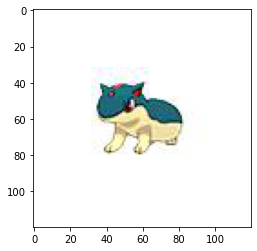

quilava is Fire. model predicted Fire


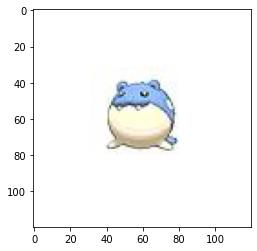

spheal is Water. model predicted Water


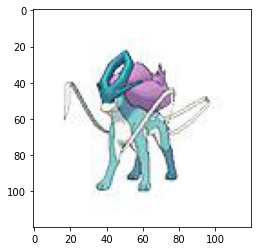

suicune is Water. model predicted Fire


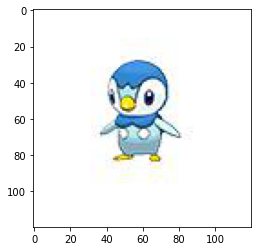

piplup is Water. model predicted Water


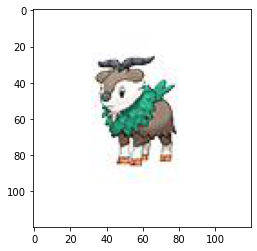

skiddo is Grass. model predicted Fire


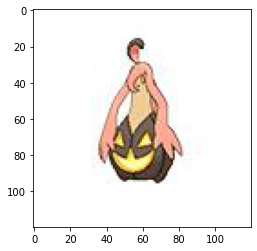

gourgeist-average is Grass. model predicted Fire


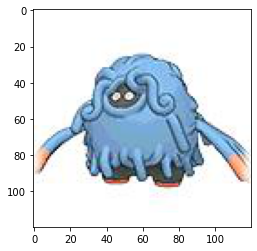

tangrowth is Grass. model predicted Water


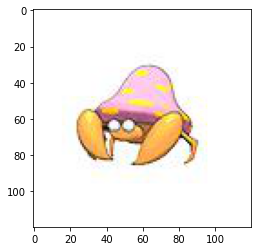

parasect is Grass. model predicted Fire


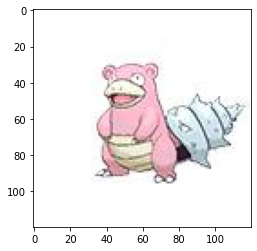

slowbro is Water. model predicted Fire


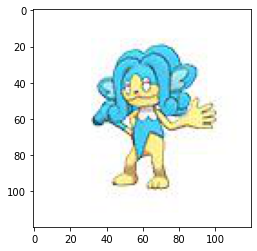

simipour is Water. model predicted Fire


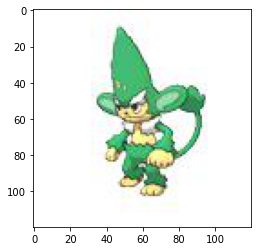

simisage is Grass. model predicted Fire


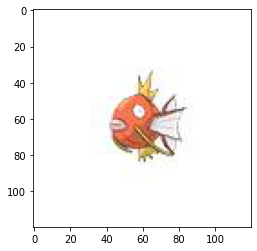

magikarp is Water. model predicted Fire


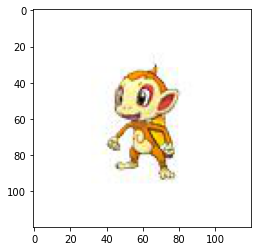

chimchar is Fire. model predicted Fire


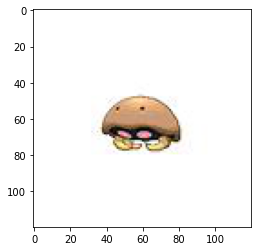

kabuto is Water. model predicted Fire


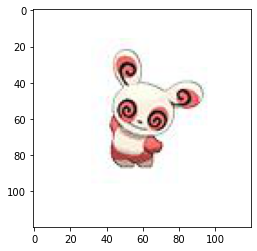

spinda is Normal. model predicted Fire


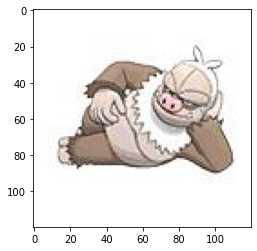

slaking is Normal. model predicted Water


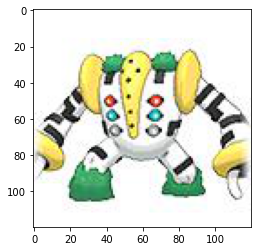

regigigas is Normal. model predicted Fire


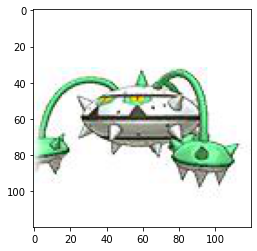

ferrothorn is Grass. model predicted Fire


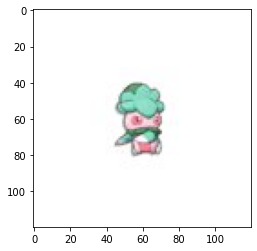

fomantis is Grass. model predicted Fire


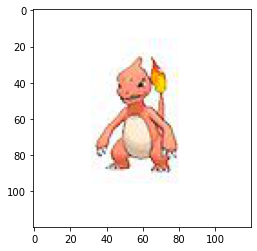

charmeleon is Fire. model predicted Fire


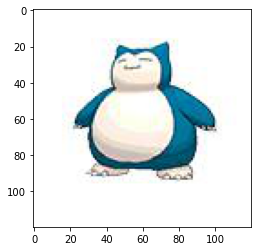

snorlax is Normal. model predicted Fire


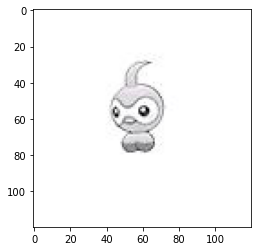

castform is Normal. model predicted Fire


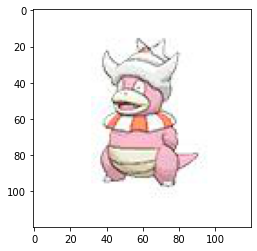

slowking is Water. model predicted Fire


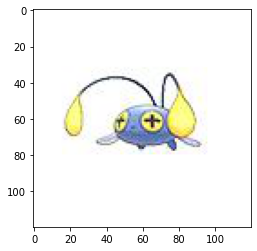

chinchou is Water. model predicted Fire


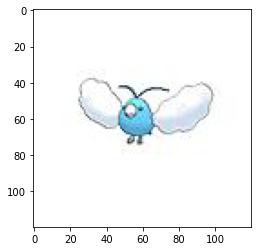

swablu is Normal. model predicted Fire


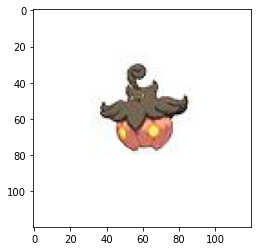

pumpkaboo-average is Grass. model predicted Fire


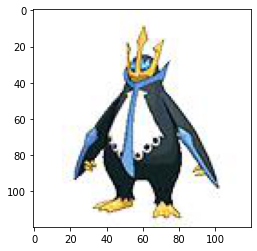

empoleon is Water. model predicted Fire


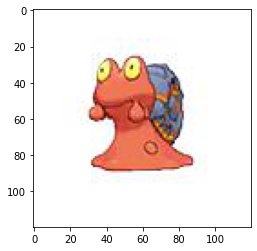

magcargo is Fire. model predicted Fire


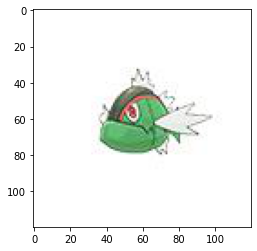

basculin-red-striped is Water. model predicted Fire


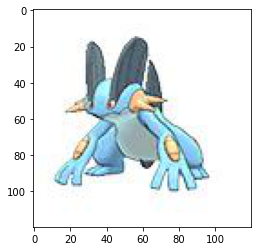

swampert is Water. model predicted Water


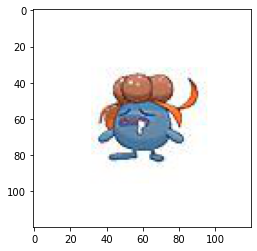

gloom is Grass. model predicted Fire


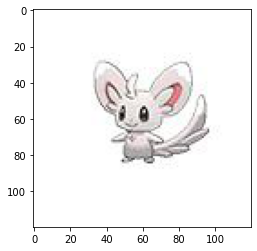

minccino is Normal. model predicted Fire


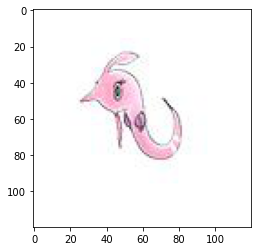

gorebyss is Water. model predicted Fire


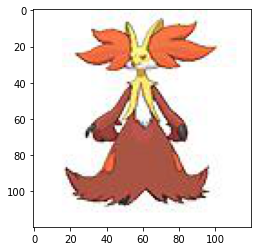

delphox is Fire. model predicted Fire


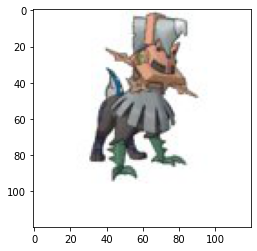

type-null is Normal. model predicted Fire


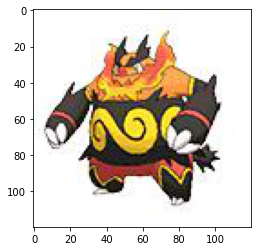

emboar is Fire. model predicted Fire


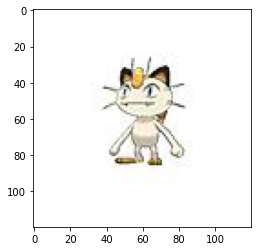

meowth is Normal. model predicted Fire


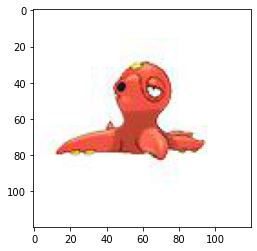

octillery is Water. model predicted Fire


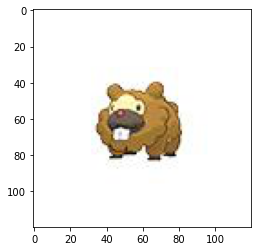

bidoof is Normal. model predicted Fire


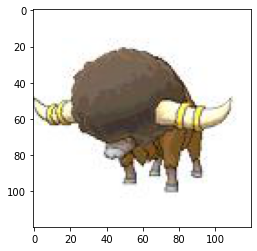

bouffalant is Normal. model predicted Fire


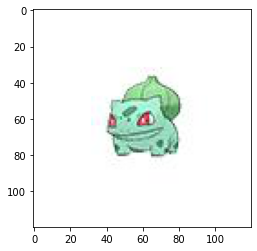

bulbasaur is Grass. model predicted Fire


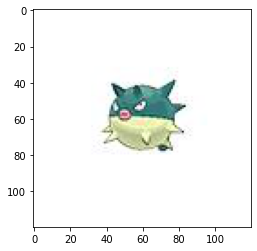

qwilfish is Water. model predicted Fire


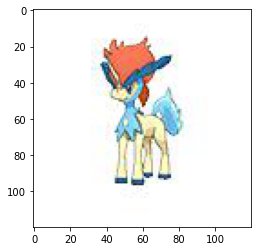

keldeo-ordinary is Water. model predicted Fire


In [11]:
for y, z in zip(y_predict, z_test):
    actual_type = type_mapping_reversed[pokemon_type_mapping[z]]
    predicted_type = type_mapping_reversed[np.argmax(y)]

    %matplotlib inline
    i = mpimg.imread(f'images/{z}.jpg')
    plt.imshow(i)
    plt.show()

    print(f'{z} is {actual_type}. model predicted {predicted_type}')